In [1]:
import pandas as pd
import atomica.ui as au

Atomica 0.16.0 (2018-07-31) -- (c) the Atomica development team
2018-08-01 13:59:18.945913
git branch: framework-plotting (66c2c1d)


Sciris 0.6.1 (2018-07-28) without web library (see sciris.web_error for details)


# Frameworks



The _framework_ is an object that represents the transition structure of the model in Atomica. It contains a listing of all of the compartments, characteristics, and parameters, as well as the transition matrix that links parameters with transitions between compartments. It does not contain a specification of the populations, because these are entered in the databook. This page assumes familiarity with basic Atomica concepts (e.g., compartments, characteristics, parameters, populations) and is intended as technical documentation on the implementation of the framework.

A 'framework' exists in two forms:

- The 'framework file' which is an `xlsx` file, such as `framework_tb.xlsx`
- A Python object, `ProjectFramework`, which is stored in `Project.framework` and is constructed by parsing the framework file

On the user input side, users of Atomica implementing new cascade models etc. will typically be modifying the framework file. On the development size, Python code can generally expect to interact with the `ProjectFramework` object. A key goal is to make the `ProjectFramework` as flexible as possible to accommodate changes in the Excel file, to maximize the extent to which changes in a project can be performed in the framework file without needing complex changes in the codebase.

## `ProjectFramework` basics

The `ProjectFramework` class stores a parsed, validated representation of the framework file. The framework file consists of a set of sheets, with content on each of the sheets. An example from the TB framework is shown below

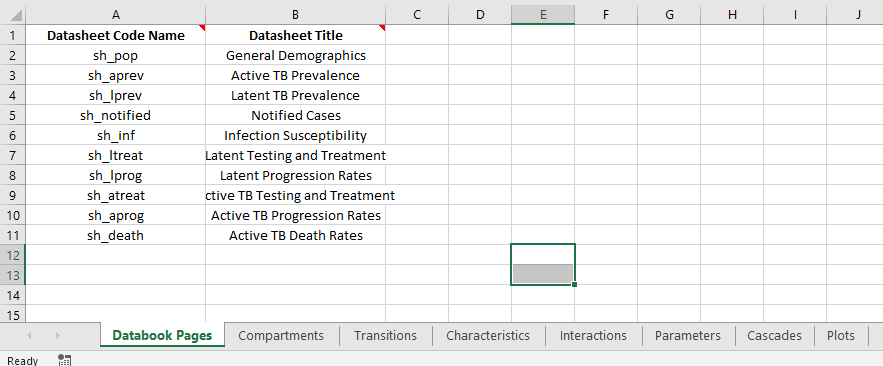

Here we can see that there are a number of worksheets in the file ('Databook Pages', 'Compartments', 'Transitions',...) and there is of course content on each sheet. 

The `ProjectFramework` contains a member variable, `sheets`, which is an odict where the key is the sheet name and the value is a Pandas `DataFrame` that contains the contents of that sheet.

In [2]:
F = au.ProjectFramework("../tests/frameworks/framework_tb.xlsx")
F.sheets.keys()

['Databook Pages',
 'Compartments',
 'Transitions',
 'Characteristics',
 'Interactions',
 'Parameters',
 'Cascades',
 'Plots']

In [3]:
F.sheets['Databook Pages']

,Datasheet Code Name,Datasheet Title
1,sh_pop,General Demographics
2,sh_aprev,Active TB Prevalence
3,sh_lprev,Latent TB Prevalence
4,sh_notified,Notified Cases
5,sh_inf,Infection Susceptibility
6,sh_ltreat,Latent Testing and Treatment
7,sh_lprog,Latent Progression Rates
8,sh_atreat,Active TB Testing and Treatment
9,sh_aprog,Active TB Progression Rates
10,sh_death,Active TB Death Rates


Some sheets contain multiple elements. For example, consider the 'Cascades' sheet here:

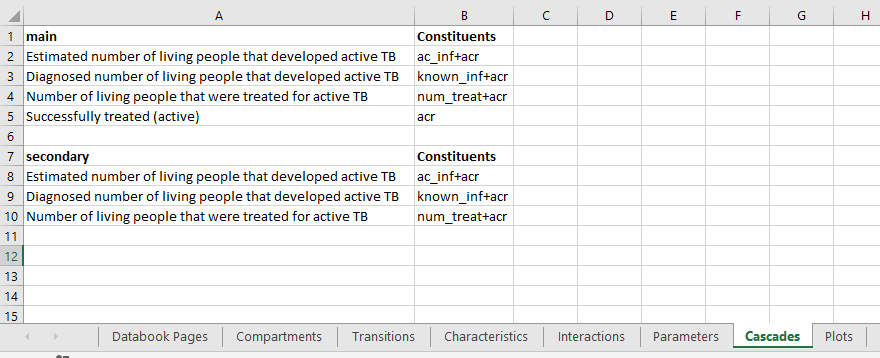

Intuitively, this sheet contains two separate 'tables' that each have a heading row, and they are separated by a blank row. When a worksheet is parsed, if there are any blank rows, multiple `DataFrames` will be instantiated, one for each 'table' present on the page. As shown below, `F.sheets['Cascades']` is a list of `DataFrames`, and each `DataFrame` stores the contents of one of the tables:

In [4]:
type(F.sheets['Cascades'])

list

In [5]:
len(F.sheets['Cascades'])

2

In [6]:
F.sheets['Cascades'][0]

,main,Constituents
1,Estimated number of living people that develop...,ac_inf+acr
2,Diagnosed number of living people that develop...,known_inf+acr
3,Number of living people that were treated for ...,num_treat+acr
4,Successfully treated (active),acr


In [7]:
F.sheets['Cascades'][1]

,secondary,Constituents
1,Estimated number of living people that develop...,ac_inf+acr
2,Diagnosed number of living people that develop...,known_inf+acr
3,Number of living people that were treated for ...,num_treat+acr


<div class="alert alert-success">
The code parses Excel sheets into `DataFrames` in `ProjectFramework.__init__()` and **this initial stage of parsing is blind to the contents of the worksheet**. This means that all columns of all sheets will be loaded into `DataFrames`. Any new columns added by the user in the framework file will automatically appear in the `DataFrame` when the framework file is loaded.
</div>

### Accessing the data

You can access the contents from the Excel file by operating on the `DataFrame`. Notice how in the previous examples, the first row of each 'table' is assumed to be a heading and is set as the `Columns` property of the `DataFrame`. This means those column names can be used as normal to index the `DataFrame`:

In [8]:
# This is the DataFrame from the 'Databook Pages' sheet
F.sheets['Databook Pages']

,Datasheet Code Name,Datasheet Title
1,sh_pop,General Demographics
2,sh_aprev,Active TB Prevalence
3,sh_lprev,Latent TB Prevalence
4,sh_notified,Notified Cases
5,sh_inf,Infection Susceptibility
6,sh_ltreat,Latent Testing and Treatment
7,sh_lprog,Latent Progression Rates
8,sh_atreat,Active TB Testing and Treatment
9,sh_aprog,Active TB Progression Rates
10,sh_death,Active TB Death Rates


In [9]:
# This is a listing of just the 'Datasheet Title' column. The name should be an identical match
# to the title in the Excel file. These titles are set directly based on the contents of the Excel
# file. If the title is changed in the Excel file, then references to it in the code will need
# to be updated in order to reflect this
F.sheets['Databook Pages']['Datasheet Title']

1                General Demographics
2                Active TB Prevalence
3                Latent TB Prevalence
4                      Notified Cases
5            Infection Susceptibility
6        Latent Testing and Treatment
7            Latent Progression Rates
8     Active TB Testing and Treatment
9         Active TB Progression Rates
10              Active TB Death Rates
Name: Datasheet Title, dtype: object

<div class="alert alert-success">
As these are just ordinary `DataFrames`, you can work with them in the same way as any other `DataFrame` in regards to indexing, accessing rows/columns, filling values etc. 
</div>

### Exporting a Framework

By design, although a `ProjectFramework` can be pickled and saved as an object, it cannot be exported back to a spreadsheet. Users are not expected to require the ability to programatically modify framework files (in contrast, they _are_ expected to programatically modify databooks).

### Making a new Framework

It is no longer necessary to export a blank framework file from the code - simply copy `atomica/core/framework_template.xlsx` to start a new template. That Excel file now has a lot of extra validation and autocompletion to facilitate creating new Frameworks. This will be outlined in detail in the user guide.

### Validating the input

When a `ProjectFramework` is instantiated, it will read in everything in the Excel file. However, it is up to the code to actually use the variables contained in the framework. For example, a new column could be added to store an additional property of say, a compartment. However, it won't have any effect on the simulation unless code is written to take advantage of this (e.g., `model.py` might use the new property to treat those compartments differently).

This presents a challenge - what should be done if the `ProjectFramework` does not contain something that is required by the code? The simplest solution is that the user's custom code can simply check whether a particular sheet, a particular column, or a particular value is present in the `ProjectFramework` and act accordingly. 

If you don't want the logic of your code to be complicated by the additional validation checks, or if the code is performance-critical and you only want to validate values once, you can instead perform the validation when the `ProjectFramework` is loaded. The method `ProjectFramework._validate()` is automatically called after the spreadsheet is read in. At the moment, it mainly contains validation of the basic elements of an Atomica model - for example, ensuring that compartments, characteristics, parameters, and the transition matrix are present. Here are some of the standard checks that are performed

1. Requiring that a sheet is present - an error will be thrown if the sheet is missing. For example, if the 'Compartments' sheet is missing, then the Framework is essentially unusable
2. Checking whether a property is present - for example, if the 'Compartments' page is missing the 'Code Name' column then the Framework is considered unusable 
3. Validating the contents of specified fields - for example, the 'Is Source' field for a compartment can only be 'y' or 'n' so an error will result if a different value was entered in the framework file
4. Filling in any missing values with defaults - for example, if a 'Compartment' has an empty cell for 'Is Source' then it will default to 'no'

The last three of those checks are implemented in `framework.py:sanitize_dataframe()` so they can be readily used for any `DataFrame` that is loaded in.

In addition to this, arbitrary validation can also be performed at this point. For example, `ProjectFramework._validate()` checks here that there are no transitions from a normal compartment to a source compartment. 



## Adding a quantity to the Framework

<div class="alert alert-success">
Adding something to the Framework can be done simply by adding an extra column or extra sheet. `DataFrames` associated with every Table on the page will be created. These can then be accessed directly from the Framework. In the simplest case, you can perform validation (like checking if a quantity was provided in the framework) at the point you want to use the quantity. 
</div>

However, if you want to validate the new variables when the framework is loaded, then you will need to modify `ProjectFramework._validate()`. To add a default quantity, look at how default values for compartments etc. are handled in that function. 


## Convenience methods

First and foremost, the role of the `ProjectFramework` is to store information about compartments, characteristics, parameters, interactions, and transitions, because those are are the fundamental building blocks of `Model` objects, and simulations cannot be run without them. These are accessed so frequently that the `ProjectFramework` provides some special methods to facilitate working with them. 

First, the `Transitions` sheet is handled in a special way. As with every other sheet, it appears in the `.sheets` property:

In [10]:
F.sheets['Transitions'].head()

,None,sus,vac,lteu,ltet,ltlu,ltlt,ltr,ltex,ltlx,...,acr,bir,immi,ddis,doth,emi,None,None,None,None
1,sus,None,v_rate,l_inf,None,None,None,None,None,None,...,None,None,None,None,doth_rate,e_rate,None,None,None,None
2,vac,None,None,None,None,None,None,None,v_inf,None,...,None,None,None,None,doth_rate,e_rate,None,None,None,None
3,lteu,None,None,None,le_treat,lu_prog,None,None,None,None,...,None,None,None,None,doth_rate,e_rate,None,None,None,None
4,ltet,None,None,le_fail,None,None,None,le_succ,None,None,...,None,None,None,None,doth_rate,e_rate,None,None,None,None
5,ltlu,None,None,None,None,None,ll_treat,None,None,None,...,None,None,None,None,doth_rate,e_rate,None,None,None,None


However, this format is not very helpful for actually working with transitions. The `ProjectFramework` stores a special parsed representation of this in `ProjectFramework.transitions` which is an odict where the key is a parameter name, and the value is a list of tuples for every transition that parameter governs:

In [11]:
print(F.transitions['b_rate'])
print(F.transitions['doth_rate'])

[('bir', 'sus')]
[('sus', 'doth'), ('vac', 'doth'), ('lteu', 'doth'), ('ltet', 'doth'), ('ltlu', 'doth'), ('ltlt', 'doth'), ('ltr', 'doth'), ('ltex', 'doth'), ('ltlx', 'doth'), ('spdu', 'doth'), ('spdd', 'doth'), ('spdt', 'doth'), ('spmu', 'doth'), ('spmd', 'doth'), ('spmt', 'doth'), ('spxu', 'doth'), ('spxd', 'doth'), ('spxt', 'doth'), ('sndu', 'doth'), ('sndd', 'doth'), ('sndt', 'doth'), ('snmu', 'doth'), ('snmd', 'doth'), ('snmt', 'doth'), ('snxu', 'doth'), ('snxd', 'doth'), ('snxt', 'doth'), ('acr', 'doth')]


This also illustrates an example of where validation is used - the parsing will fail unresolvably if the `Transitions` sheet is missing from the framework file, so `ProjectFramework._validate()` first checks that the sheet is present and displays an informative error if it is missing.

Next, the `DataFrames` for compartments, characteristics, parameters, and interactions have the 'Code Name' column set as the index for the `DataFrame`:

In [12]:
F.sheets['Compartments'].head()

,Display Name,Is Source,Is Sink,Is Junction,Setup Weight,Can Calibrate,Databook Page,Databook Order,Export
Code Name,,,,,,,,,
sus,Susceptible,n,n,n,0,n,None,None,n
vac,Vaccinated,n,n,n,1,n,sh_lprev,None,n
lteu,Early latent untreated (diagnosable),n,n,n,1,n,sh_lprev,None,n
ltet,Early latent on treatment,n,n,n,1,n,sh_lprev,None,n
ltlu,Late latent untreated (diagnosable),n,n,n,1,n,sh_lprev,None,n


This means that you can access a row of this `DataFrame` using `.loc` and passing in the code name of the quantity. For example:

In [13]:
F.sheets['Compartments'].loc['sus']

Display Name      Susceptible
Is Source                   n
Is Sink                     n
Is Junction                 n
Setup Weight                0
Can Calibrate               n
Databook Page            None
Databook Order           None
Export                      n
Name: sus, dtype: object

As usual, the `.loc` method returns a Pandas `Series` object, which is similar to a `dict()`. Note that the `name` of the `Series` is the code name of the quantity i.e.

In [14]:
F.sheets['Compartments'].loc['sus'].name

'sus'

This allows you to retrieve the code name based only on the `Series` object - so for example, if you retrieved that row by index rather than by name 

In [15]:
row = F.sheets['Compartments'].iloc[0]
print(row)

Display Name      Susceptible
Is Source                   n
Is Sink                     n
Is Junction                 n
Setup Weight                0
Can Calibrate               n
Databook Page            None
Databook Order           None
Export                      n
Name: sus, dtype: object


then you can still recover the name

In [16]:
row.name

'sus'

Because the column names have also been set in the `DataFrame`, you can index the `Series` using the column name to retrieve a specific property. For example, if we want to check which databook page the `vac` compartment is on:

In [17]:
F.sheets['Compartments'].loc['vac']['Databook Page']

'sh_lprev'

The column names are read straight from the Excel file - any additional columns will automatically appear and be usable. Note that there should be an exact match between the name of the column in the Excel file, and the string used in the code (for example, you could not use `F.sheets['Compartments'].loc['vac']['Databook page']` because it is case sensitive)

For convenience, the `.comps`, `.pars`, `.characs`, and `.interactions` property methods map to their corresponding sheets. That is, `F.comps` is shorthand for `F.sheets['Compartments']`. So the above command could instead be

In [18]:
F.comps.loc['vac']['Databook Page']

'sh_lprev'

Those properties directly return the `DataFrame` in `F.sheets` so if you modify the `DataFrame` via `F.comps` it will be changed everywhere. 

Finding specific items by their code name is very common. To facilitate this, you can use the `.get_comp`, `.get_charac`, `.get_par`, and `.get_interaction` property methods to look up rows of the corresponding `DataFrames` by code name. For example, to retrieve the row for `vac`, instead of `F.comps.loc['vac']` you can use

In [19]:
F.get_comp('vac')

Display Name      Vaccinated
Is Source                  n
Is Sink                    n
Is Junction                n
Setup Weight               1
Can Calibrate              n
Databook Page       sh_lprev
Databook Order          None
Export                     n
Name: vac, dtype: object

So looking up the databook page can be made even simpler:

In [20]:
F.get_comp('vac')['Databook Page']

'sh_lprev'

Sometimes you might know the code name without knowing the type of the variable - for example, only given the code name `'alive'`, should you be looking up a compartment or a characteristic? In that case, you can use the `.get_variable()` method which will search for the name in each of compartments, characteristics, parameters, and interactions. The return value is a tuple where the first entry is the row of the `DataFrame`, and the second entry is a string like `'comp'`, `'par'`, `'charac'`, which identifies what type of variable was passed in

In [21]:
F.get_variable('vac')

(Display Name      Vaccinated
 Is Source                  n
 Is Sink                    n
 Is Junction                n
 Setup Weight               1
 Can Calibrate              n
 Databook Page       sh_lprev
 Databook Order          None
 Export                     n
 Name: vac, dtype: object, 'comp')

Finally, sometimes you might have the display name, and not the code name. You can also pass a display name into `get_variable()` and it will retrieve the corresponding item

In [22]:
F.get_variable('Vaccinated')

(Display Name      Vaccinated
 Is Source                  n
 Is Sink                    n
 Is Junction                n
 Setup Weight               1
 Can Calibrate              n
 Databook Page       sh_lprev
 Databook Order          None
 Export                     n
 Name: vac, dtype: object, 'comp')

Note that these functions rely on the fact that code names and display names are supposed to be unique across all of the different variable types (i.e. not only can you not have two compartments with the same name, you cannot give a parameter the same name as a compartment). This is checked for in `ProjectFramework._validate()`.

## Iterating over items

The simplest way to iterate over rows of a `DataFrame` is using the `iterrows()` method of the `DataFrame`. For example, to loop over all compartments, you could use:

In [23]:
for _,row in F.comps.iterrows():
    print('%s-%s' % (row.name,row['Is Source']))

sus-n
vac-n
lteu-n
ltet-n
ltlu-n
ltlt-n
ltr-n
ltex-n
ltlx-n
acj-n
spj-n
spdu-n
spdd-n
spdt-n
spmu-n
spmd-n
spmt-n
spxu-n
spxd-n
spxt-n
snj-n
sndu-n
sndd-n
sndt-n
snmu-n
snmd-n
snmt-n
snxu-n
snxd-n
snxt-n
acr-n
bir-y
immi-y
ddis-n
doth-n
emi-n


Notice how the `.name` property can be used inside the loop in order to identify the code name for the row.

Although simple, this operation is relatively computationally expensive because it creates a `Series` object for every row. If performance is critical (for example, during `Model.build()`) then it is better to use the `.at` method of the `DataFrame`. For example:

In [24]:
F.comps.at['sus','Is Source']

'n'

In a loop, you would then have to first look up the index values and then iterate over them:

In [25]:
for comp_name in list(F.comps.index):
    print('%s-%s' % (comp_name,F.comps.at[comp_name,'Is Source']))

sus-n
vac-n
lteu-n
ltet-n
ltlu-n
ltlt-n
ltr-n
ltex-n
ltlx-n
acj-n
spj-n
spdu-n
spdd-n
spdt-n
spmu-n
spmd-n
spmt-n
spxu-n
spxd-n
spxt-n
snj-n
sndu-n
sndd-n
sndt-n
snmu-n
snmd-n
snmt-n
snxu-n
snxd-n
snxt-n
acr-n
bir-y
immi-y
ddis-n
doth-n
emi-n
